In [83]:
# -*- coding: utf-8 -*-
"""
Filter and clean sentinel 2 data
Top part: one station 
Bottom part: loop over all stations 
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
from scipy import interpolate
import statsmodels.api as sm
import scipy
import Functions



def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]
%run Functions.py

path_sentinel = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/data/Google_EVI_LSWI/'
path_sentinel_new = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/data/Sentinel2/'


In [84]:
unique = []
for i in range(2017, 2021):
    df, sl = get_stations_year(i)
    sl = sl.tolist()
    unique = list(set(sl + unique))
print(unique)
len(unique)

['FI-Let', 'SE-Svb', 'FI-Hyy', 'SE-Htm', 'SE-Lnn', 'SE-Ros', 'SE-Nor', 'SE-Deg', 'FI-Qvd']


9

In [92]:
station = unique[2]

evi_df = pd.read_csv(path_sentinel + 'EVI_'+ station+'.csv')

evi_df['Datetime'] = pd.to_datetime(evi_df['system:time_start'], format= '%b %d, %Y')
#evi_df.drop_duplicates(subset='Datetime', keep=False, inplace=True)

In [94]:
evi_df.tail(30)
# duplicates : either the 2 sattelites, or error or day an dnight, range, 
# doesnt exist for all days, all stations 

,system:time_start,constant_max,constant_mean,constant_min,Datetime
438,"Sep 7, 2020",0.79,0.361,0.031,2020-09-07
439,"Sep 7, 2020",0.796,0.359,0.028,2020-09-07
440,"Sep 14, 2020",31.923,0.163,-61.609,2020-09-14
441,"Sep 14, 2020",468.5,0.270,-126.786,2020-09-14
442,"Sep 19, 2020",1.134,0.122,-0.123,2020-09-19
443,"Sep 19, 2020",1.074,0.121,-0.133,2020-09-19
444,"Sep 24, 2020",NaN,NaN,NaN,2020-09-24
445,"Sep 24, 2020",NaN,NaN,NaN,2020-09-24
446,"Sep 27, 2020",0.676,0.291,0.034,2020-09-27
447,"Sep 27, 2020",0.676,0.290,0.04,2020-09-27


### 1. Get overview about data duplicates, nans and seasonal distribution of evi and lswi of each season

In [95]:
evi_df['year'] = evi_df['Datetime'].dt.year
EVI= []
for i, row in evi_df.iterrows():
    try:
        evi = float(row['constant_mean'])

    except :
        evi = np.nan

    EVI.append(evi)

evi_df['EVI_mean'] = EVI
evi_df.loc[evi_df['EVI_mean'] > 1, 'EVI_mean'] = np.nan
evi_df.loc[evi_df['EVI_mean'] < 0, 'EVI_mean'] = np.nan

<AxesSubplot:xlabel='Datetime'>

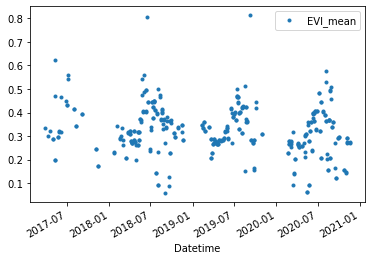

In [96]:
# plotting data of one station
evi_df.plot(x = 'Datetime', y = 'EVI_mean', style='.')

In [97]:
original_length = []
new_length = []
station_counts = []

winter_counts = []
autumn_counts = []
summer_counts = []
spring_counts = []

# winter 21 december, spring 20 march, summer 21 june, autumn 23 september
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
month_to_season 

for station in unique:
    evi_df = pd.read_csv(path_sentinel + 'EVI_'+ station+'.csv')
    evi_df['Datetime'] = pd.to_datetime(evi_df['system:time_start'], format= '%b %d, %Y')
    evi_df['year'] = evi_df['Datetime'].dt.year
    EVI= []
    for i, row in evi_df.iterrows():
        try:
            evi = float(row['constant_mean'])

        except :
            evi = np.nan

        EVI.append(evi)

    evi_df['EVI_mean'] = EVI
    evi_df.loc[evi_df['EVI_mean'] > 1, 'EVI_mean'] = np.nan
    evi_df.loc[evi_df['EVI_mean'] < 0, 'EVI_mean'] = np.nan
    original_length.append(len(evi_df))
    evi_df = evi_df.drop_duplicates(subset=['Datetime'],keep= 'first')
    new_length.append(len(evi_df))
    station_counts.append(evi_df['EVI_mean'].count())
    evi_df['season'] = evi_df.Datetime.dt.month.map(month_to_season) 
    winter_counts.append(evi_df[evi_df['season']== 1].count()['EVI_mean'])
    autumn_counts.append(evi_df[evi_df['season']== 4].count()['EVI_mean'])
    summer_counts.append(evi_df[evi_df['season']== 3].count()['EVI_mean'])
    spring_counts.append(evi_df[evi_df['season']== 2].count()['EVI_mean'])

In [98]:
data = {'station':unique,
        'original_len':original_length, 
        'dublicate_len':new_length,
        'not_nan_counts': station_counts,
        'winter': winter_counts,
       'spring': spring_counts,
       'summer': summer_counts,
       'autum': autumn_counts}
overview_df_evi = pd.DataFrame(data) 

In [99]:
overview_df_evi

,station,original_len,dublicate_len,not_nan_counts,winter,spring,summer,autum
0,FI-Let,513,265,193,18,70,66,39
1,SE-Svb,369,366,278,25,86,99,68
2,FI-Hyy,468,243,183,12,63,75,33
3,SE-Htm,547,318,193,29,52,59,53
4,SE-Lnn,300,297,212,30,65,75,42
5,SE-Ros,368,366,276,23,82,99,72
6,SE-Nor,552,284,206,20,61,68,57
7,SE-Deg,368,366,223,11,51,98,63
8,FI-Qvd,290,289,194,19,62,71,42


In [76]:
original_length_l = []
new_length_l = []
station_counts_l = []

winter_counts_l = []
autumn_counts_l = []
summer_counts_l = []
spring_counts_l = []

# winter 21 december, spring 20 march, summer 21 june, autumn 23 september
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
month_to_season 

for station in unique:
    lswi_df = pd.read_csv(path_sentinel + 'LSWI_'+ station+'.csv')
    lswi_df['Datetime'] = pd.to_datetime(lswi_df['system:time_start'], format= '%b %d, %Y')
    lswi_df['year'] = lswi_df['Datetime'].dt.year
    LSWI= []
    for i, row in lswi_df.iterrows():
        try:
            lswi = float(row['nd_mean'])

        except :
            lswi = np.nan

        LSWI.append(lswi)
    lswi_df['lswi_mean'] = LSWI
    lswi_df.loc[lswi_df['lswi_mean'] > 1, 'lswi_mean'] = np.nan
    lswi_df.loc[lswi_df['lswi_mean'] < -1, 'lswi_mean'] = np.nan
    original_length_l.append(len(lswi_df))
    lswi_df = lswi_df.drop_duplicates(subset=['Datetime'],keep= 'first')
    new_length_l.append(len(lswi_df))
    station_counts_l.append(lswi_df['lswi_mean'].count())
    lswi_df['season'] = lswi_df.Datetime.dt.month.map(month_to_season) 
    winter_counts_l.append(lswi_df[lswi_df['season']== 1].count()['lswi_mean'])
    autumn_counts_l.append(lswi_df[lswi_df['season']== 4].count()['lswi_mean'])
    summer_counts_l.append(lswi_df[lswi_df['season']== 3].count()['lswi_mean'])
    spring_counts_l.append(lswi_df[lswi_df['season']== 2].count()['lswi_mean'])

In [77]:
data = {'station':unique,
        'original_len':original_length_l, 
        'dublicate_len':new_length_l,
        'not_nan_counts': station_counts_l,
        'winter': winter_counts_l,
       'spring': spring_counts_l,
       'summer': summer_counts_l,
       'autum': autumn_counts_l}
overview_df_lswi = pd.DataFrame(data) 
overview_df_lswi

,station,original_len,dublicate_len,not_nan_counts,winter,spring,summer,autum
0,FI-Let,513,265,199,19,70,69,41
1,SE-Svb,369,366,282,25,88,101,68
2,FI-Hyy,468,243,183,12,63,75,33
3,SE-Htm,547,318,200,30,54,62,54
4,SE-Lnn,300,297,221,34,67,77,43
5,SE-Ros,368,366,290,24,93,101,72
6,SE-Nor,552,284,209,21,61,69,58
7,SE-Deg,368,366,280,25,91,99,65
8,FI-Qvd,290,289,204,22,68,71,43


### 2. Clean out data, interpolate and create new csv files 
#### 2.1 For one station with plots

2017-04-27 2020-11-27
[[1.72840000e+04 2.61787959e-01]
 [1.72850000e+04 2.65464771e-01]
 [1.72860000e+04 2.69164483e-01]
 ...
 [1.85910000e+04 2.78200949e-01]
 [1.85920000e+04 2.81832617e-01]
 [1.85930000e+04 2.85509879e-01]]


/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


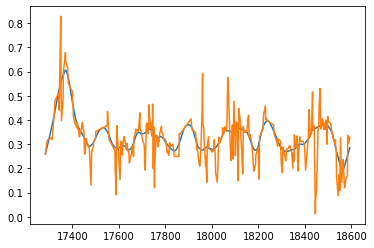

In [3]:
EVI = []
for i, row in evi_df.iterrows():
    try:
        evi = float(row['constant_mean'])

    except :
        evi = np.nan
        
    EVI.append(evi)

evi_df['EVI_mean'] = EVI
evi_df.loc[evi_df['EVI_mean'] > 1, 'EVI_mean'] = np.nan
evi_df.loc[evi_df['EVI_mean'] < 0, 'EVI_mean'] = np.nan

xp= evi_df['Datetime'].values
fp = evi_df['EVI_mean'].values

nans, f = nan_helper(fp)
fp[nans] = np.interp(f(nans), f(~nans) , fp[~nans])

xp = xp.astype('datetime64[D]')

xmin = np.min(xp)
xmax = np.max(xp)
# print(xmin, xmax)
x = np.arange(xmin, xmax+np.timedelta64(1, 'D'), step=datetime.timedelta(days=1) )
x = x.astype('datetime64[D]').astype(int)
xp = xp.astype('datetime64[D]').astype(int)

f = interpolate.interp1d(xp, fp, fill_value='extrapolate')
evi_int = f(x)

lowess = sm.nonparametric.lowess
z = lowess(evi_int, x, frac=0.05)
# print(z)

y_n = z[:,1]
x_n = z[:,0]
plt.plot(x_n, y_n)
plt.plot(x, evi_int)
plt.show()

EVI = y_n

2017-04-27 2020-11-27
[[1.72840000e+04 3.00732861e-01]
 [1.72850000e+04 2.99330819e-01]
 [1.72860000e+04 2.97944657e-01]
 ...
 [1.85910000e+04 1.61848066e-01]
 [1.85920000e+04 1.60105247e-01]
 [1.85930000e+04 1.58393310e-01]]


/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


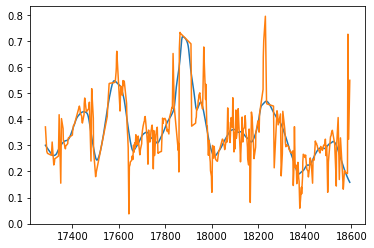

In [4]:
lswi_df = pd.read_csv(path_sentinel + 'LSWI_'+ station+'.csv')

lswi_df['Datetime'] = pd.to_datetime(lswi_df['system:time_start'], format= '%b %d, %Y')
#lswi_df.drop_duplicates(subset='Datetime', keep=False, inplace=True)
LSWI = []
for i, row in lswi_df.iterrows():
    try:
        lswi = float(row['nd_mean'])

    except :
        lswi = np.nan
        
    LSWI.append(lswi)


lswi_df['LSWI_mean'] = LSWI
lswi_df.loc[lswi_df['LSWI_mean'] > 1, 'LSWI_mean'] = np.nan
lswi_df.loc[lswi_df['LSWI_mean'] < -1, 'LSWI_mean'] = np.nan

xp= lswi_df['Datetime'].values
fp = lswi_df['LSWI_mean'].values

nans, f = nan_helper(fp)
fp[nans] = np.interp(f(nans), f(~nans) , fp[~nans])               
                  
xp = xp.astype('datetime64[D]')

xmin = np.min(xp)
xmax = np.max(xp)
print(xmin, xmax)
x = np.arange(xmin, xmax+np.timedelta64(1, 'D'), step=datetime.timedelta(days=1) )
x = x.astype('datetime64[D]').astype(int)
xp = xp.astype('datetime64[D]').astype(int)

f = interpolate.interp1d(xp, fp, fill_value='extrapolate')
lswi_int = f(x)

lowess = sm.nonparametric.lowess
z = lowess(lswi_int, x, frac=0.05)
print(z)

y_n = z[:,1]
x_n = z[:,0]
plt.plot(x_n, y_n)
plt.plot(x, lswi_int)
LSWI = y_n


In [6]:
final_df = pd.DataFrame()
final_df['Dates'] = x_n.astype('datetime64[D]')
final_df['EVI_mean'] = EVI
final_df['LSWI_mean'] = LSWI
print(final_df)
path_sentinel_new = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/data/Sentinel2/'
final_df.to_csv(path_sentinel_new + station+'_500m.csv', index = False)

          Dates  EVI_mean  LSWI_mean
0    2017-04-28  0.261788   0.300733
1    2017-04-29  0.265465   0.299331
2    2017-04-30  0.269164   0.297945
3    2017-05-01  0.272889   0.296574
4    2017-05-02  0.276638   0.295217
...         ...       ...        ...
1305 2020-11-23  0.271077   0.165432
1306 2020-11-24  0.274616   0.163623
1307 2020-11-25  0.278201   0.161848
1308 2020-11-26  0.281833   0.160105
1309 2020-11-27  0.285510   0.158393

[1310 rows x 3 columns]


#### 2.2. For all stations 

In [27]:
for station in unique:  
    evi_df = pd.read_csv(path_sentinel + 'EVI_'+ station+'.csv')
    evi_df['Datetime'] = pd.to_datetime(evi_df['system:time_start'], format= '%b %d, %Y')
    EVI = []
    for i, row in evi_df.iterrows():
        try:
            evi = float(row['constant_mean'])

        except :
            evi = np.nan

        EVI.append(evi)

    evi_df['EVI_mean'] = EVI
    evi_df.loc[evi_df['EVI_mean'] > 1, 'EVI_mean'] = np.nan
    evi_df.loc[evi_df['EVI_mean'] < 0, 'EVI_mean'] = np.nan

    xp= evi_df['Datetime'].values
    fp = evi_df['EVI_mean'].values

    nans, f = nan_helper(fp)
    fp[nans] = np.interp(f(nans), f(~nans) , fp[~nans])

    xp = xp.astype('datetime64[D]')

    xmin = np.min(xp)
    xmax = np.max(xp)
    x = np.arange(xmin, xmax+np.timedelta64(1, 'D'), step=datetime.timedelta(days=1) )
    x = x.astype('datetime64[D]').astype(int)
    xp = xp.astype('datetime64[D]').astype(int)

    f = interpolate.interp1d(xp, fp, fill_value='extrapolate')
    evi_int = f(x)
    lowess = sm.nonparametric.lowess
    z = lowess(evi_int, x, frac=0.05)
    y_n = z[:,1]
    x_n = z[:,0]

    EVI = y_n
    
#     Get the lswi    
    lswi_df = pd.read_csv(path_sentinel + 'LSWI_'+ station+'.csv')
    lswi_df['Datetime'] = pd.to_datetime(lswi_df['system:time_start'], format= '%b %d, %Y')
    LSWI = []
    for i, row in lswi_df.iterrows():
        try:
            lswi = float(row['nd_mean'])

        except :
            lswi = np.nan

        LSWI.append(lswi)

    lswi_df['LSWI_mean'] = LSWI
    lswi_df.loc[lswi_df['LSWI_mean'] > 1, 'LSWI_mean'] = np.nan
    lswi_df.loc[lswi_df['LSWI_mean'] < -1, 'LSWI_mean'] = np.nan

    xp= lswi_df['Datetime'].values
    fp = lswi_df['LSWI_mean'].values

    nans, f = nan_helper(fp)
    fp[nans] = np.interp(f(nans), f(~nans) , fp[~nans])               

    xp = xp.astype('datetime64[D]')

    xmin = np.min(xp)
    xmax = np.max(xp)
    print(xmin, xmax)
    x = np.arange(xmin, xmax+np.timedelta64(1, 'D'), step=datetime.timedelta(days=1) )
    x = x.astype('datetime64[D]').astype(int)
    xp = xp.astype('datetime64[D]').astype(int)

    f = interpolate.interp1d(xp, fp, fill_value='extrapolate')
    lswi_int = f(x)

    lowess = sm.nonparametric.lowess
    z = lowess(lswi_int, x, frac=0.05)
    y_n = z[:,1]
    x_n = z[:,0]

    LSWI = y_n
    
    final_df = pd.DataFrame()
    final_df['Dates'] = x_n.astype('datetime64[D]')
    final_df['EVI_mean'] = EVI
    final_df['LSWI_mean'] = LSWI
    final_df.to_csv(path_sentinel_new + station+'_500m.csv', index = False)

    
    

2017-03-31 2020-11-09
2017-04-03 2020-12-25
2017-03-31 2020-11-09


/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


2017-04-10 2020-12-25


/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


2017-04-03 2020-12-25


/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


2017-03-29 2020-12-23


/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


2017-04-27 2020-11-27


/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/nfs/pic.es/user/m/mdomhoef/.conda/envs/env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


2017-03-29 2020-11-18
2017-03-31 2020-11-09
2017-03-29 2020-12-23
